In [1]:
import importlib
import itertools
import json
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from sys import path
from copy import copy, deepcopy
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as dt

In [2]:
path.append("ingestion_program/")
path.append("../Data_Generator")
path.append("DANN_program/")
path.append("sample_code_submission/")
path.append("visualize/")
path.append("params/")

In [3]:
from params import Params 
from setting import Setting 
from data_generator_physics import DataGenerator

In [4]:
data_name = 'fair_universe_challenge'
settings_dir = 'data_jsons\DANN_jsons_for_physics\Translation'
data_dir = 'sample_data' 
number_of_samples = 5000

***
# 1 - Generate Params
***

## 1.1 - Nuisance magnitude

In [5]:
# Standard deviation of signal and background distributions
sigma = 0.5

# Proportion of 1 sigma circles overlapping.
# If set to 0.9, it means that we want the 1 sigma circle associated to the target distribution will be so that
# it shares 90% of its area with the 1 sigma circle associated to the source distribution.
overlapping_props = np.array([1,0.95,0.75,0.5])

In [6]:
def compute_nuisance_magnitude (sigma, prop) :
    d = -6*(1-prop)*np.pi
    Delta = d**2+4**4
    x = 0.5*(1-prop)*np.pi
    # We couldn't find an exact solution for x. Thus we performed the approximation sin(x) ~ x as x tends toward 0.
    print("Error made while approaching x : \n \n", pd.DataFrame(np.vstack([prop,np.sin(x)-x]).transpose(),index=None,columns=["overlapping_prop", "error on x"]))
    delta = 2*sigma*np.sin(x/2)
    print("\n", pd.DataFrame(np.vstack([prop,np.nan_to_num(2*sigma*np.cos(x/2)*0.5*np.abs(np.sin(x)-x)/delta*100,nan=0)]).transpose(),index=None,columns=["overlapping_prop", "percentage of error on delta"]))

    return delta

In [7]:
deltas = compute_nuisance_magnitude(sigma, overlapping_props)

Error made while approaching x : 
 
    overlapping_prop  error on x
0              1.00    0.000000
1              0.95   -0.000081
2              0.75   -0.010016
3              0.50   -0.078291

    overlapping_prop  percentage of error on delta
0              1.00                      0.000000
1              0.95                      0.102724
2              0.75                      2.517603
3              0.50                      9.450606


## 1.2 - Nuisance angle

In [8]:
alphas = [135,45]

In [9]:
def draw_circles (sigma, delta, alphas) :
    fig, axs = plt.subplots(1,2,figsize=(11,5)) 
    for ax,alpha in zip(axs,alphas) :
        circle_source = plt.Circle((0,0),sigma,fill=False,color="k",label="Train distribution")
        circle_target = plt.Circle((delta*np.cos(np.radians(alpha)),
                              delta*np.sin(np.radians(alpha))),
                              sigma,fill=False,color="k",ls='--',label="Test distribution")
        arrow = plt.Arrow(0,0,
                          0.6*sigma*np.cos(np.radians(alpha)),
                          0.6*sigma*np.sin(np.radians(alpha)),
                          width=0.3*sigma,color="r",label="Nuisance direction")

        ax.axhline(y=0, linestyle='-.', color='g')
        ax.axvline(x=0, linestyle='-.', color='g')
        ax.add_patch(circle_source)
        ax.add_patch(circle_target)
        ax.add_patch(arrow)
        ax.set_xlim(-2*sigma,3*sigma)
        ax.set_ylim(-2*sigma,3*sigma)
        ax.legend()
    plt.suptitle("Circles radius $\sigma=$ {}. Circles centers distance $\delta=${}".format(sigma,np.round(delta,3)))
    plt.show()

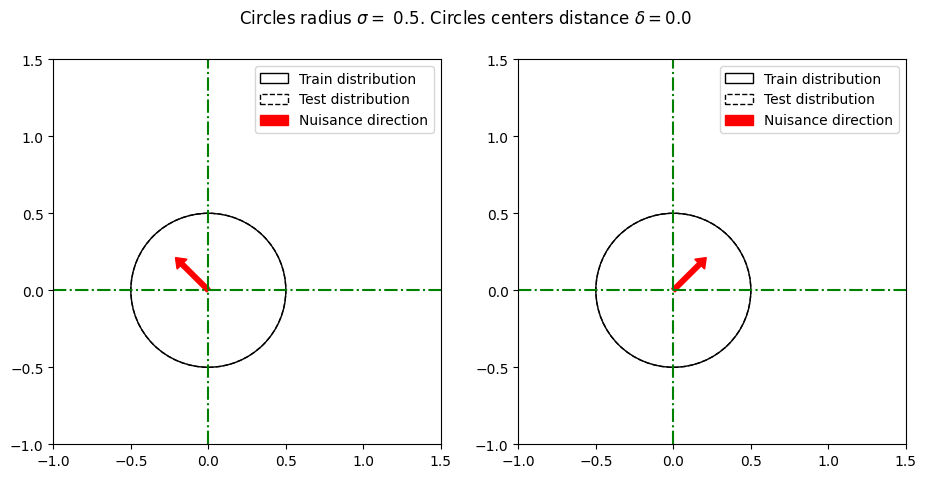

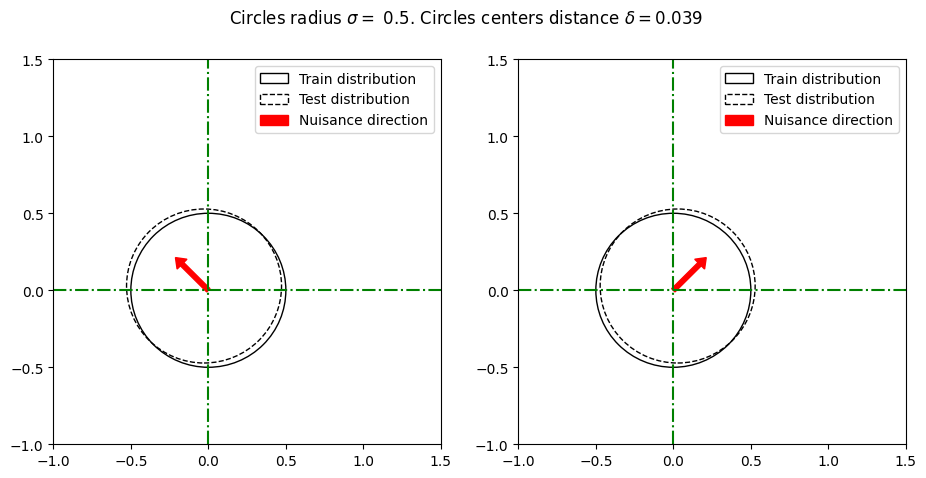

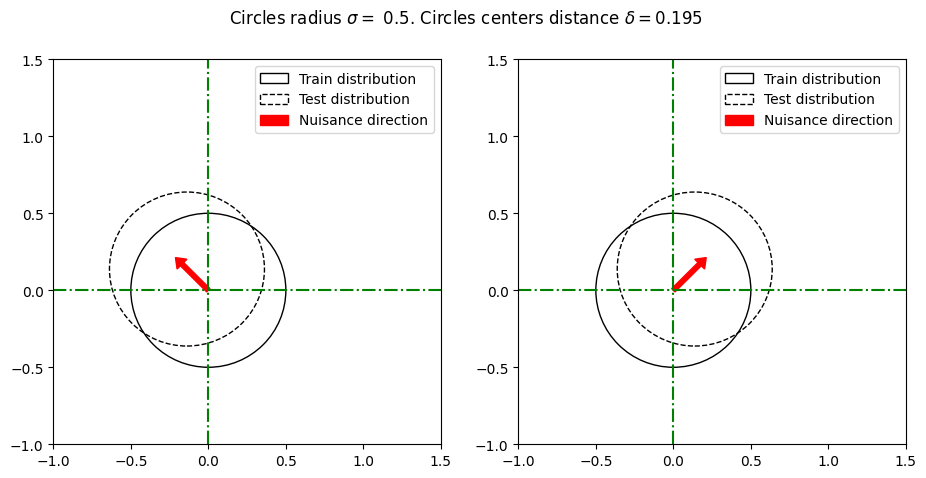

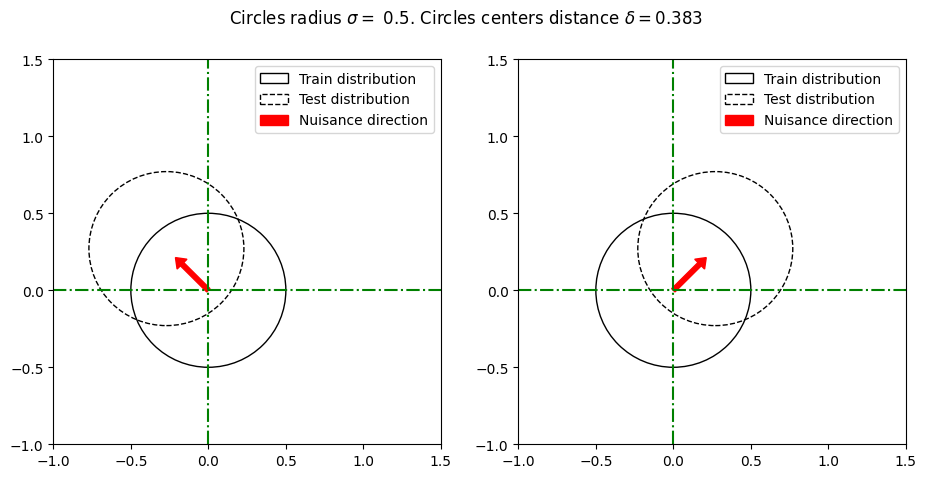

In [10]:
for delta in deltas :
    draw_circles(sigma,delta,alphas)

## 1.3 - Define systematics

In [11]:
from data_loader import get_settings_from_json

In [12]:
systematics_list = []
for z in deltas :
    systematics_left = [{
            "name": "Translation",
            "z_range": [z,z],
            "z_angles": [alphas[0]]}]
    systematics_right = [{
            "name": "Translation",
            "z_range": [z,z],
            "z_angles": [alphas[1]]}]
    systematics_list.append((systematics_left,systematics_right))

## 1.4 - Other params

In [13]:
nb_datasets = 10

In [14]:
def generate_params (systematics) :
    data_gen_settings_train = []
    data_gen_settings_test = []
    data_gen_params_train = []
    data_gen_params_test = []

    for i in range(0,nb_datasets):

        # Generate train params 
        data_gen_param_train = Params(
            pi=0.5,
            nu_1=number_of_samples,
            mu_range=[1.0, 1.0], 
            systematics=[],
            verbose=False
        )

        # Save params 
        data_gen_params_train.append(data_gen_param_train)

        # Generate setting from params for data generation
        settings_files = get_settings_from_json(settings_dir)
        data_gen_settings_train.append(Setting(case=i+1, params=data_gen_param_train, imported_settings=settings_files[0]).get_setting())

    for i in range(0,nb_datasets):

        # Generate test params 
        data_gen_param_test = Params(
            pi=0.5,
            nu_1=number_of_samples,
            mu_range=[0.9, 1.1], 
            systematics=systematics,
            verbose=False
        )

        # Save params 
        data_gen_params_test.append(data_gen_param_test)

        # Generate setting from params for data generation
        settings_files = get_settings_from_json(settings_dir)
        data_gen_settings_test.append(Setting(case=i+1, params=data_gen_param_test, imported_settings=settings_files[0]).get_setting())
        
    return (data_gen_settings_train, data_gen_settings_test, data_gen_params_train, data_gen_params_test)

In [15]:
settings_list = []
params_list = []
for systematics_left, systematics_right in systematics_list :
    left_params = generate_params(systematics_left)
    right_params = generate_params(systematics_right)
    settings_list.append((left_params[0:2],right_params[0:2]))
    params_list.append((left_params[2:4],right_params[2:4]))

In [16]:
np.shape(settings_list)

(4, 2, 2, 10)

- we test 4 proportion values (1,0.95,0.75 and 0.5)
- for each proportion, we compare 2 angles (45 and 135)
- for each angle, we generate 2 kinds of set (train and set)
- for each kind of set, we generate 10 sets

In [17]:
print([settings_list[0][0][1][i]["systematics"][0]["alpha"] for i in range(10)])

[135, 135, 135, 135, 135, 135, 135, 135, 135, 135]


***
# 2 - Generate Data
***

In [18]:
def generate_train_test_sets (data_gen_settings_train, data_gen_settings_test, directory) :
    for index, (train_settings, test_settings) in enumerate(zip(data_gen_settings_train, data_gen_settings_test)):

        # Train data
        data_gen_train = DataGenerator(settings_dict=train_settings)
        data_gen_train.generate_data()
        data_gen_train.save_data(directory=directory, data_type="train", file_index=index+1)

        # Test data
        data_gen_test = DataGenerator(settings_dict=test_settings)
        data_gen_test.generate_data()
        data_gen_test.save_data(directory=directory, data_type="test", file_index=index+1)  
    

In [19]:
start = dt.now()

for i in range(len(settings_list)) :
    delta_dir = data_dir + "/z_{}".format(np.round(deltas[i],3))
    os.makedirs(delta_dir, exist_ok=True) if os.path.isdir(delta_dir) else None
    #os.makedirs('directory_path', exist_ok=True) if os.path.isdir('directory_path') else None
    for j in range(len(settings_list[i])) :
        alpha_dir = delta_dir + "/alpha_{}".format(alphas[j])
        data_gen_settings_train, data_gen_settings_test = settings_list[i][j]
        generate_train_test_sets(data_gen_settings_train, data_gen_settings_test,alpha_dir)

print(f"Elapsed Time: {dt.now() - start}")

Elapsed Time: 0:00:04.619450


In [20]:
from data_io import load_data, show_data_statistics, write

In [21]:
sets_list = []
for delta in deltas :
    alpha_list = []
    for alpha in alphas :
        train_sets = load_data(data_dir + "/z_{}/alpha_{}".format(np.round(deltas[i],3),alphas[j]), "train")
        test_sets = load_data(data_dir + "/z_{}/alpha_{}".format(np.round(deltas[i],3),alphas[j]), "test")
        alpha_list.append((train_sets,test_sets))
    sets_list.append(alpha_list)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data/z_0.383/alpha_45\train\data
[*] labels dir :  sample_data/z_0.383/alpha_45\train\labels
[*] settings dir :  sample_data/z_0.383/alpha_45\train\settings
[+] data dir found
[+] labels dir found
[+] settings dir found
[+] 10 datsets found
---------------------------------
[+] Data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data/z_0.383/alpha_45\test\data
[*] labels dir :  sample_data/z_0.383/alpha_45\test\labels
[*] settings dir :  sample_data/z_0.383/alpha_45\test\settings
[+] data dir found
[+] labels dir found
[+] settings dir found
[+] 10 datsets found
---------------------------------
[+] Data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------

In [22]:
np.shape(sets_list)

(4, 2, 2, 10)

***
# 3 - Baseline with DANN
***

In [23]:
from training.new_trainer import Trainer
import training.new_trainer
Trainer = importlib.reload(training.new_trainer).Trainer

In [24]:
theta_candidates = np.linspace(-2,2,50)
theta_candidates

array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
       -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
       -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
       -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0.44897959,
       -0.36734694, -0.28571429, -0.20408163, -0.12244898, -0.04081633,
        0.04081633,  0.12244898,  0.20408163,  0.28571429,  0.36734694,
        0.44897959,  0.53061224,  0.6122449 ,  0.69387755,  0.7755102 ,
        0.85714286,  0.93877551,  1.02040816,  1.10204082,  1.18367347,
        1.26530612,  1.34693878,  1.42857143,  1.51020408,  1.59183673,
        1.67346939,  1.75510204,  1.83673469,  1.91836735,  2.        ])

In [25]:
models_settings =[{"model_type" : "DANN",
                 "Model_settings" : {
                     "display_name": "NB",
                     "model_name": "NB",
                     "preprocessing": False,
                     "preprocessing_method": "translation"},
                 "DANN_settings" : {
                     "model_name" : "DANN_1",
                     "input_size" : (2,),
                     "hp_lambda" : 10.0,
                     "class_weights" : [1,1],
                     "num_epochs" :15,
                     "batch_size" : 50,
                     "preprocessing": False}}]

In [26]:
result_dir = "sample_result_submission/DANN"
model_dir = "None"

trainers_list = []
for i in range(len(settings_list)) :
    delta_dir = result_dir + "/z_{}".format(np.round(deltas[i],3))
    os.makedirs(delta_dir, exist_ok=True)
    delta_trainers = []
    for j in range(len(settings_list[i])) :
        alpha_dir = delta_dir + "/alpha_{}".format(alphas[j])
        os.makedirs(alpha_dir, exist_ok=True)
        trainer = Trainer(models_settings,
                          theta_candidates,
                          alpha_dir,
                          model_dir,
                          sets_list[i][j][0],
                          sets_list[i][j][1],
                          None,
                          write)
        delta_trainers.append(trainer)
    trainers_list.append(delta_trainers)

############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################
############################################
### Training Program
############################################


In [27]:
for delta_trainers in trainers_list :
    for trainer in delta_trainers :
        trainer.train()


--------------------------------------------
[*] Model : DANN_1 --- Preprocessing: False
--------------------------------------------

	Dataset : 1
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
153/153 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_RO

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_

153/153 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2

		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Es


--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
156/156 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Es

	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2653061224489797 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.183673469387755 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.1020408163265307 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.0204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.9387755102040818 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
	

	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
152/152 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 2
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734

		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.59


--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
150/150 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 7
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
156/156 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
156/156 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 9
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
155/155 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.12244897959183687 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.12244897959183643 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.2857142857142856 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.36734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estima

152/152 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 2
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.6938775510204083 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.6122448979591837 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.5306122448979593 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.44897959183673475 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.3673469387755104 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.2857142857142858 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.20408163265306145 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.122448979591

	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
156/156 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 5
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.918367

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.693877551020408 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma


--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
154/154 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estima

153/153 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2

		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
159/159 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
160/160 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_R

		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
156/156 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 5
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_

		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2653061224489797 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.183673469387755 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.1020408163265307 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.0204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.9387755102040818 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.6938775510204083 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.612244897959183

144/144 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 8
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
154/154 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
159/159 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 10
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
155/155 [=====

	[*] Theta : -0.12244897959183687 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.12244897959183643 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.2857142857142856 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.36734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.6122448979591835 
		[*] Estimate nu_ROI
		[

159/159 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
160/160 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
156/156 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 5
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI

		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
150/150 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 7
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2653061224489797 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.183673469387755 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.1020408163265307 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.0204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.9387755102040818 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Esti

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.6122448979591835 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.693877551020408 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

159/159 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

--------------------------------------------
[*] Model : DANN_1 --- Preprocessing: False
--------------------------------------------

	Dataset : 1
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
153/153 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamm

159/159 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
160/160 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

	[*] Theta : 0.2857142857142856 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.36734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.6122448979591835 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.693877551020408 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Esti

163/163 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 6
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
158/158 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
144/144 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 8
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2653061224489797 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.183673469387755 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.1020408163265307 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.0204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.9387755102040818 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Esti

	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1020408163265305 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.1836734693877546 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.2653061224489792 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.3469387755102038 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estim


--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 2ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma

		[*] Estimate gamma_ROI
	[*] Theta : 0.204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.2857142857142856 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.36734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.6122448979591835 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.693877551020408 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] E

156/156 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 5
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
157/157 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

150/150 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 7
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
156/156 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

156/156 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 9
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
155/155 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate gamma_ROI
	[*] Theta : -0.5306122448979593 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.44897959183673475 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.3673469387755104 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.2857142857142858 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.20408163265306145 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.12244897959183687 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.04081632653061229 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.12244897959183643 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.20408163265

		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
152/152 [==============================] - 0s 1ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 2
	---------------

		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.4285714285714286 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.3469387755102042 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.2653061224489797 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.183673469387755 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.1020408163265307 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.0204081632653061 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.9387755102040818 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.8571428571428572 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] The

		[*] Estimate gamma_ROI
	[*] Theta : 1.4285714285714284 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.510204081632653 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.591836734693877 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.6734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.7551020408163263 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.8367346938775508 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Get Predictions
156/156 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 5
	---------------

		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.7755102040816328 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.6938775510204083 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.6122448979591837 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.5306122448979593 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.44897959183673475 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.3673469387755104 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.2857142857142858 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.20408163265306145 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -0.12244897959183687 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] 

144/144 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores

	Dataset : 8
	----------------
	[*] Loading Model
	[*] Training Model

--------------------------------------------
[*] Model : DANN_1 
--------------------------------------------
	[*] Get scores
154/154 [==============================] - 0s 1ms/step
	[*] Theta : -2.0 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.9183673469387754 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.836734693877551 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.7551020408163265 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.6734693877551021 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.5918367346938775 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : -1.51020408

		[*] Estimate gamma_ROI
	[*] Theta : 0.2857142857142856 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.36734693877551017 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.4489795918367343 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.5306122448979589 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.6122448979591835 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.693877551020408 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.7755102040816326 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.8571428571428568 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 0.9387755102040813 
		[*] Estimate nu_ROI
		[*] Estimate beta_ROI
		[*] Estimate gamma_ROI
	[*] Theta : 1.020408163265306 
		[*] E

159/159 [==============================] - 0s 2ms/step
	[*] Compute N_roi
	[*] Saving Predictions and Scores


In [28]:
results_list = []
for delta_trainers in trainers_list :
    delta_results = []
    for trainer in delta_trainers :
        train_results = trainer.get_result()
        delta_results.append(train_results)
    results_list.append(delta_results)

In [29]:
# One dataset train and test time
print(f"Train time : {results_list[0][0][0]['train_times'][0]}")
print(f"Test time : {results_list[0][0][0]['test_times'][0]}")

Train time : 0:00:08.481787
Test time : 0:00:01.459780


***
# 4 - Results
***

In [30]:
def visualize_delta_mus (data_gen_params_train, estimated_mu_train, data_gen_params_test, estimated_mu_test) :
    delta_mu_train = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_train, estimated_mu_train)]
    delta_mu_test = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_test, estimated_mu_test)]
    plt.figure(figsize=(10,4))
    plt.axhline(y=0.01,linestyle='-.', color='r', label="$\Delta\mu$ range")
    plt.axhline(y=-0.01,xmax=1.1, linestyle='-.', color='r')
    plt.plot(delta_mu_train, marker="x", label="Train")
    plt.plot(delta_mu_test, marker="x", label="Test")
    plt.title("$\Delta{\mu} = (\mu - \hat{\mu})$ ("+str(number_of_samples)+" samples)")
    plt.xlabel("Datasets")
    plt.ylabel("$\Delta{\mu} = (\mu - \hat{\mu})$")
    plt.ylim(-0.1,0.1)
    plt.legend()
    plt.show()
    
    return delta_mu_test

In [31]:
def visualize_bar_plots (deltas,alphas,estimated_mus_train_list,delta_mus_test_list) :
    labels = overlapping_props
    
    left_averages_delta_mu = []
    left_stds_delta_mu = []
    right_averages_delta_mu = []
    right_stds_delta_mu = []
    
    for delta_estimated_mu_train,delta_delta_mu_test in zip(estimated_mus_train_list,delta_mus_test_list) :
        delta_average_delta_mu = []
        delta_stds_delta_mu = []
        for estimated_mu_train,delta_mu_test in zip(delta_estimated_mu_train,delta_delta_mu_test) :
            mask = np.array(estimated_mu_train) != 0
            delta_average_delta_mu.append(np.mean(np.abs(np.array(delta_mu_test)[mask])))
            delta_stds_delta_mu.append(np.std(np.abs(np.array(delta_mu_test)[mask])))
        left_averages_delta_mu.append(delta_average_delta_mu[0])
        left_stds_delta_mu.append(delta_stds_delta_mu[0])
        right_averages_delta_mu.append(delta_average_delta_mu[1])
        right_stds_delta_mu.append(delta_stds_delta_mu[1])
            
    x = np.arange(len(labels)) 
    width = 0.35 

    fig, ax = plt.subplots()
    ax.bar(x - width/2, left_averages_delta_mu, width, yerr=left_stds_delta_mu, label='alpha={}'.format(alphas[0]))
    ax.bar(x + width/2, right_averages_delta_mu, width, yerr=right_stds_delta_mu, label='alpha={}'.format(alphas[1]))

    ax.set_title("Average $|\Delta\mu|$")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Overlapping proportion")
    ax.legend()

    plt.savefig("bar_plot.png")
    plt.show()

Visualization for $\delta$=0.0 and $lpha$=135


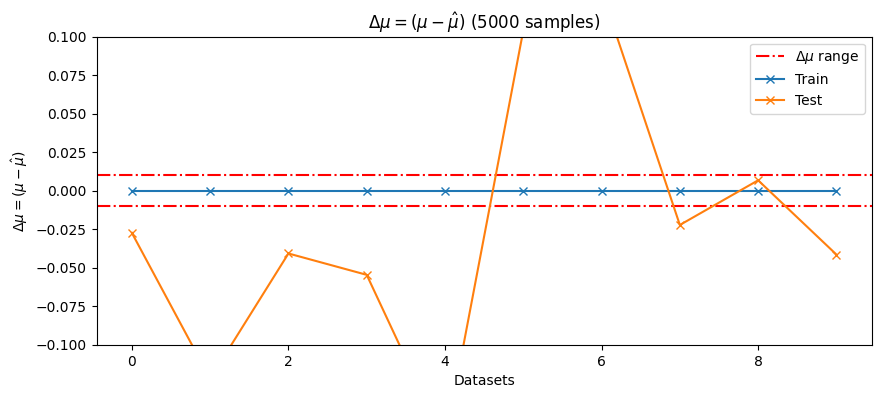

Visualization for $\delta$=0.0 and $lpha$=45


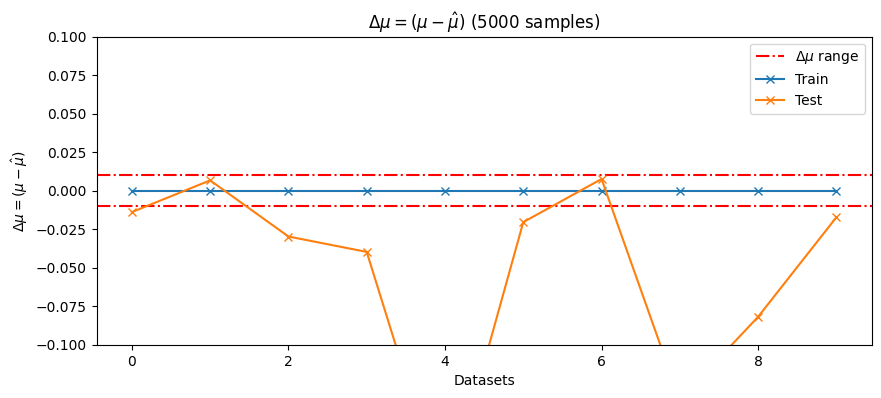

Visualization for $\delta$=0.039259815759068645 and $lpha$=135


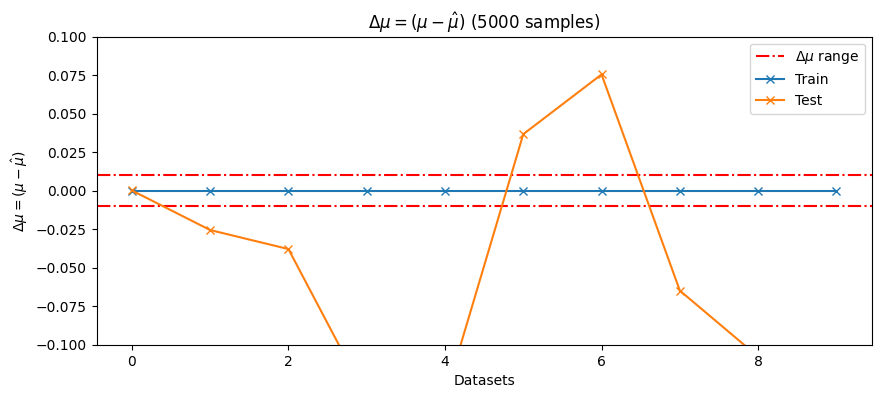

Visualization for $\delta$=0.039259815759068645 and $lpha$=45


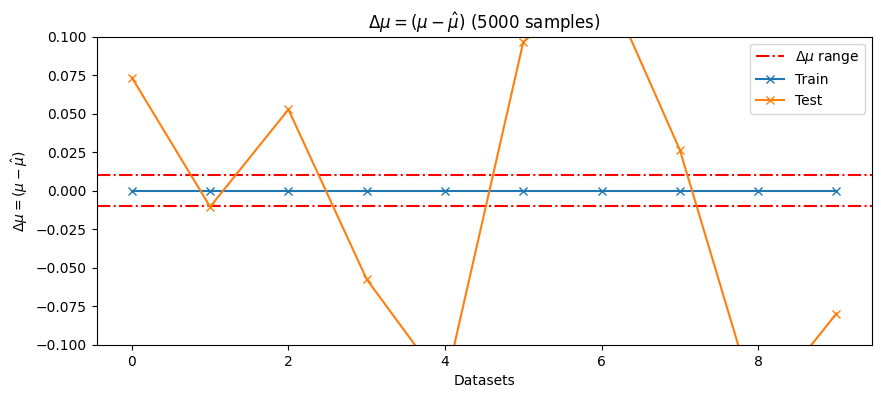

Visualization for $\delta$=0.19509032201612825 and $lpha$=135


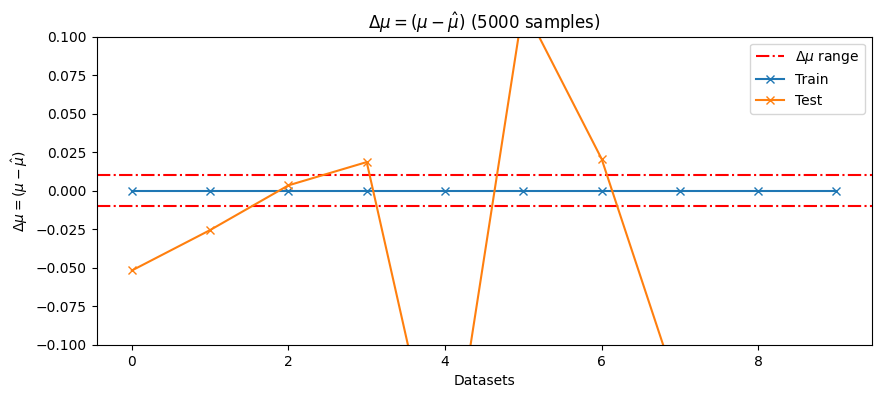

Visualization for $\delta$=0.19509032201612825 and $lpha$=45


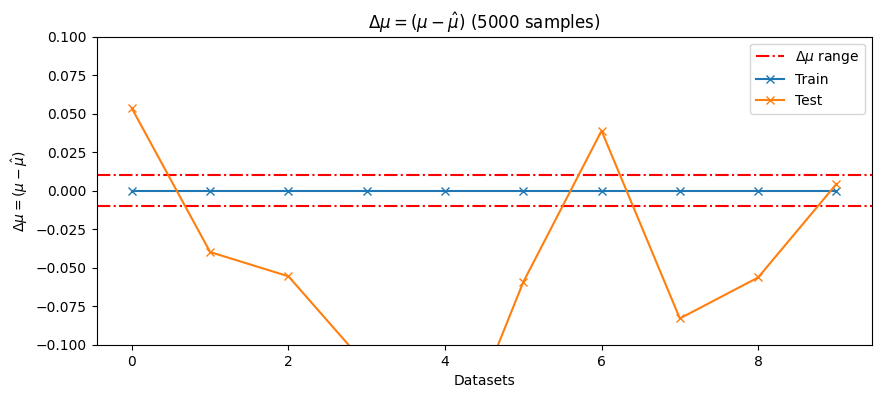

Visualization for $\delta$=0.3826834323650898 and $lpha$=135


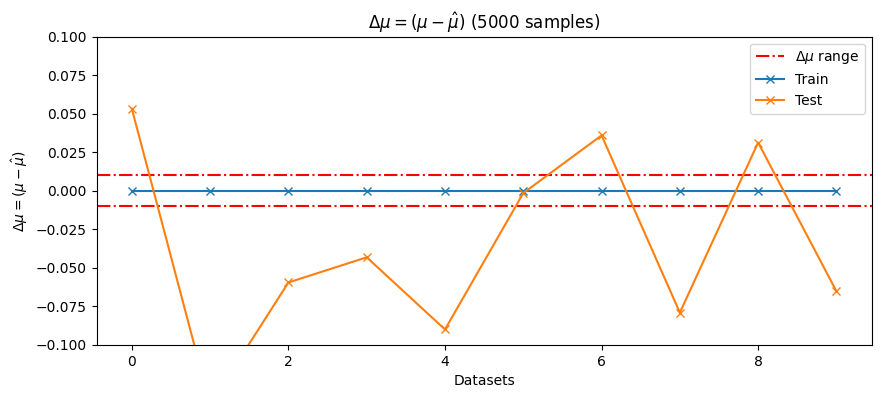

Visualization for $\delta$=0.3826834323650898 and $lpha$=45


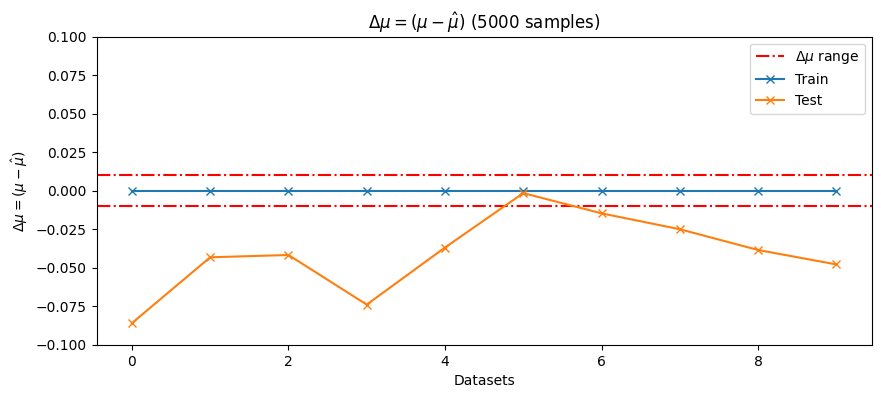

In [32]:
estimated_mus_train_list = []
delta_mus_test_list = []
for delta,delta_params,delta_results in zip(deltas,params_list,results_list) :
    delta_estimated_mus_train = []
    delta_delta_mu_test = []
    for alpha,params,results in zip(alphas,delta_params,delta_results) :
        estimated_mu_train = results[0]["mu_hat_train"]
        estimated_mu_test = results[0]["mu_hat_test"]
        delta_estimated_mus_train.append(estimated_mu_train)
        data_gen_params_train, data_gen_params_test = params
        print("Visualization for $\delta$={} and $\alpha$={}".format(delta,alpha))
        delta_mu_test=visualize_delta_mus(data_gen_params_train,estimated_mu_train,data_gen_params_test,estimated_mu_test)
        delta_delta_mu_test.append(delta_mu_test)
    estimated_mus_train_list.append(delta_estimated_mus_train)
    delta_mus_test_list.append(delta_delta_mu_test)

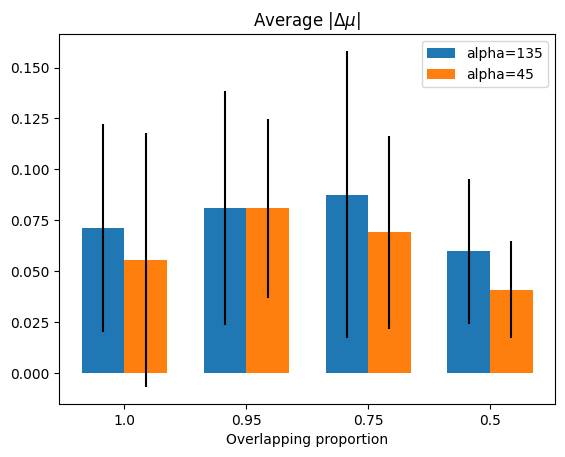

In [33]:
visualize_bar_plots(deltas,alphas,estimated_mus_train_list,delta_mus_test_list)